In this notebook I will outline the data exploration and analysis processes for this project. To see how the data was retrieved, please see the dataching_fetching notebook.

In [103]:
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import statsmodels.api as sm
sns.set_context('talk')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Getting Data for Each Metric

The data for this project has been collected and stored as csvs using the code in 'data_fetching.ipynb.' 
Here we will just be reading it in as dataframes and storing each dataframe as an entry in a dictionary

In [104]:
metrics = ['tavg', 'tmax', 'tmin', 'pcp', 'cdd', 'hdd', 'pdsi', 'phdi', 'pmdi']
all_dfs = {metric: pd.read_csv(f'cag_csvs/{metric}.csv', 
                               index_col='Date', 
                               parse_dates=['Date'])
           for metric in metrics}

### Visualizations
Let's try to get a good sense of what we actually want to model. We'll start by just taking a look at all of the available metrics for a single state.

In [105]:
def data_plot(df_dict, metric, state, start):
    ts = df_dict[metric][state]
    fig, ax = plt.subplots(figsize=(14,5))
    ax.plot(ts[start:], label = f'{metric}')
    ax.axhline(ts[start:].mean(), label = f'Average {metric}', color='g')
    ax.set_title(f" {state}'s Monthly {metric}")
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{metric}')
    ax.legend(fancybox=True, framealpha=0.4, loc='best', ncol=2)
    plt.tight_layout()

In [106]:
def MA_plot(df_dict, metric, state, start, n_months):
    ts = df_dict[metric][state]
    ts_rolling_mean = ts.rolling(n_months).mean().dropna()
    fig, ax = plt.subplots(figsize=(14,5))
    ax.plot(ts_rolling_mean[start:], label = f'{round(n_months/12, 2)} Year Rolling {metric}')
    ax.axhline(ts_rolling_mean[start:].mean(), label = f'Overall Average {metric}', color='g')
    ax.set_title(f"Long Term Changes in {state}'s {metric}")
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{metric}')
    ax.legend(fancybox=True, framealpha=0.4, loc='best', ncol=2)
    plt.tight_layout()

In [107]:
def plot_state_data(df_dict, metrics, state, start_date='1940-01-01'):

    fig, axs = plt.subplots(3, 3, sharex=True, figsize=(24, 9))

    for n, metric in enumerate(metrics):
        x = n//3
        y = n%3
        axs[x, y].plot(all_dfs[metric][state][start_date:], label = metric)
        axs[x, y].legend(loc='best')

    fig.tight_layout()

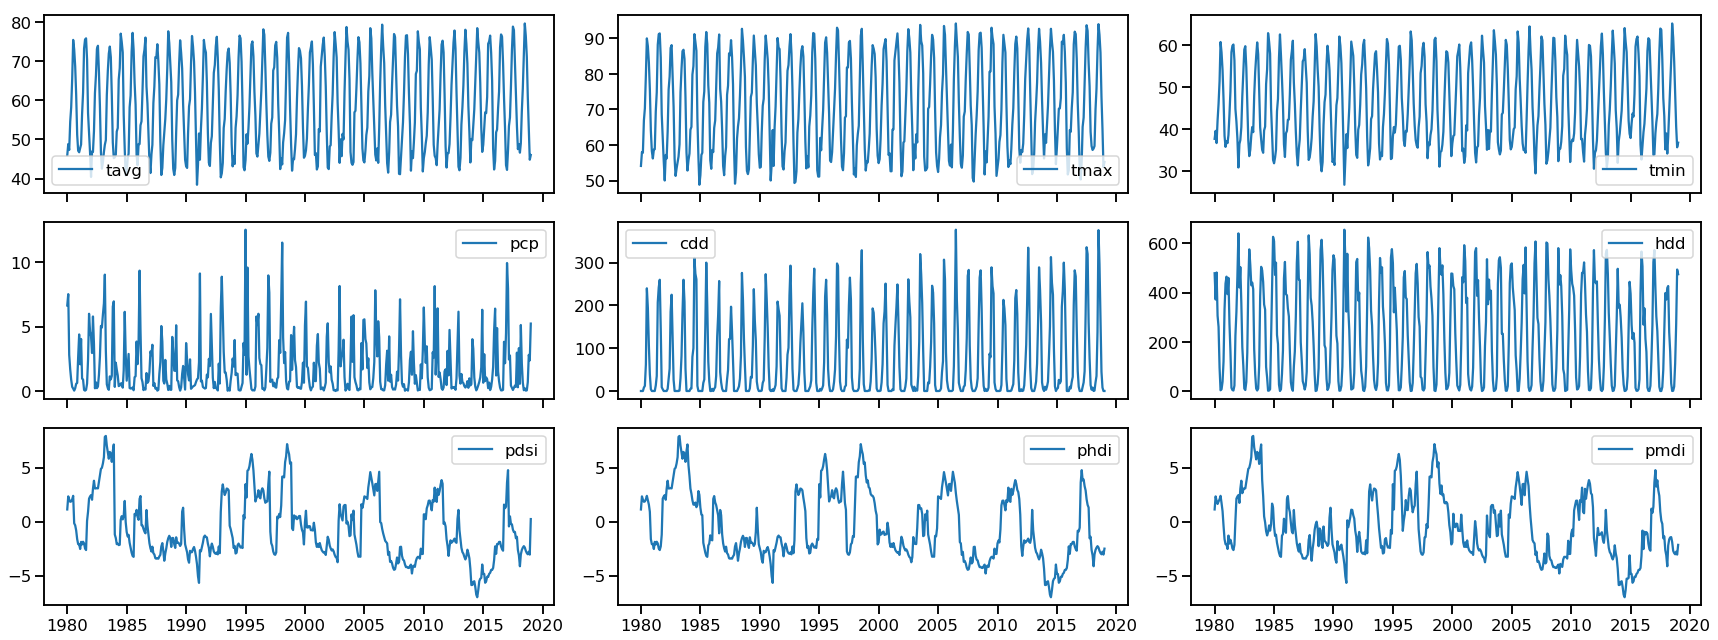

In [108]:
plot_state_data(all_dfs, metrics, 'CA', start_date='1980')

We can't really get a good look at anything in the temperature data besides the yearly seasonality. The drought indicators for CA seem to be trending downwards in more recent years, despite having periods after 2005, 2010, and 2015 where they shoot upwards. Since we can't really get a good look at the trend from this visual, we can try apply some moving averages to get a better look at where these 

In [109]:
def plot_state_MA(df_dict, metrics, state, start_date, n_months):
    
    fig, axs = plt.subplots(3, 3, sharex=True, figsize=(24, 9))

    for n, metric in enumerate(metrics):
        x = n//3
        y = n%3
        ts = all_dfs[metric][state][start_date:].rolling(n_months).mean()
        axs[x, y].plot(ts, label = metric)
        axs[x, y].legend(loc='best')
        
    fig.tight_layout()

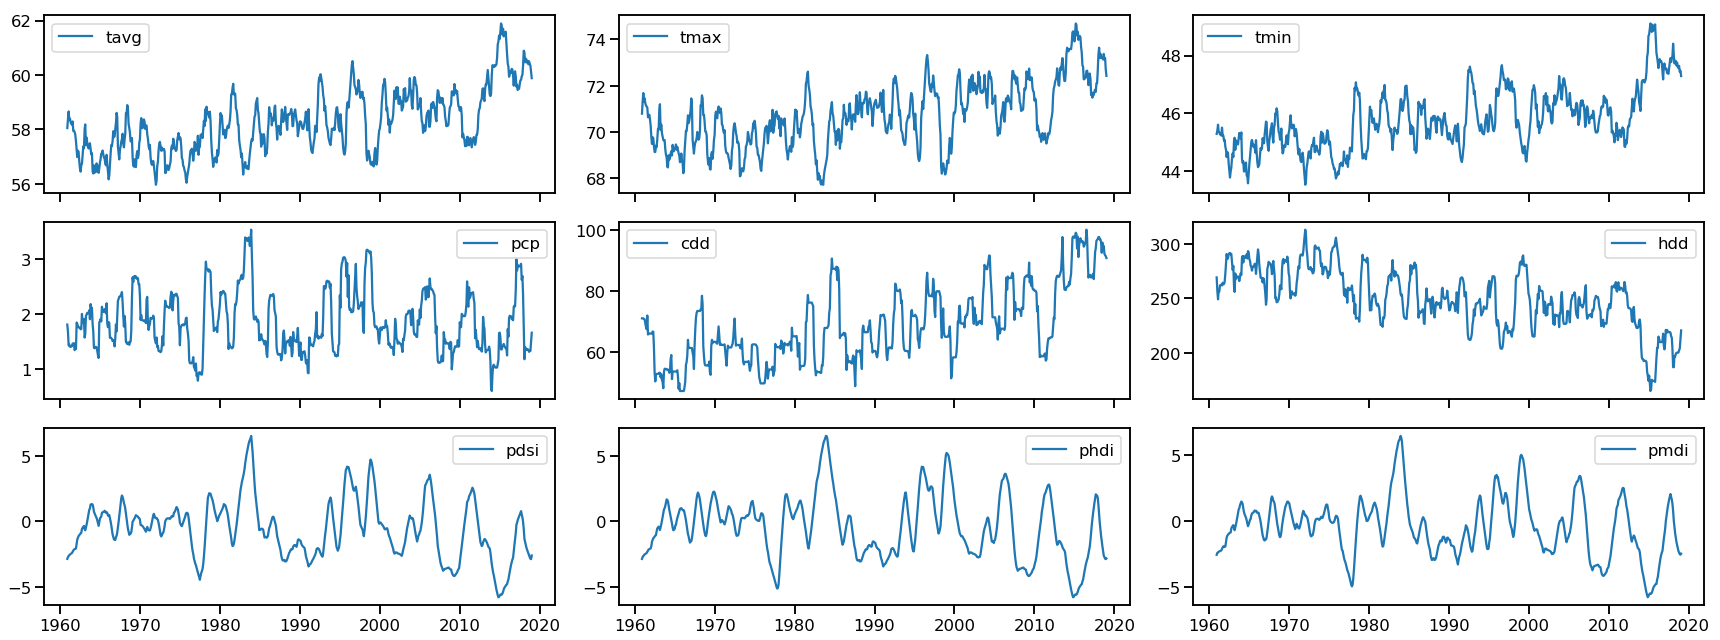

In [110]:
plot_state_MA(all_dfs, metrics, 'CA', start_date='1960-01-01', n_months=12)

With the 12 month moving average we can more clearly see some trends, especially in the temperature data. When we apply SARIMA forecasting, it will be important to recalculate the moving averages for our forecasts in order to extract the future trend.

We'll now do some seasonal and monthly differencing on our data and then take a look at the ACF and PACF as a first visual test to see what orders of differencing we need in order to achieve stationarity.

In [111]:
def differencer(df):
    """
    returns 12 month, 1 month, and 12_1 month differenced data for a dataframe or timeseries.
    """
    df_12 = df.diff(12).dropna()
    df_1 = df.diff(1).dropna()
    df_12_1 = df_12.diff(1).dropna()
    
    return df_12, df_1, df_12_1

def corr_plotter(ts, lags):
    """
    Plots the ACF and PACF for the given dataframe, states, and lags
    """
    fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(14,6), sharex=True)
    
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=axs1);
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=axs2);

In [112]:
CA_t_12, CA_t_1, CA_t_12_1 = differencer(all_dfs['tavg']['CA'])

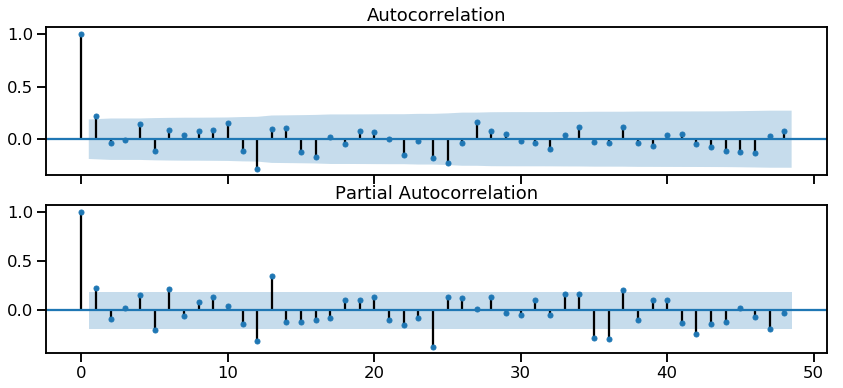

In [166]:
corr_plotter(CA_t_12['2010-01-01':], lags=48)

With a difference of 12 months (1 season) we clearly still have correlations in the data, but they are only at lags 1 and near seasonal lags of 12 months. This is a good indications that our data is actually stationary after just a seasonal difference! To be sure, we'll want to run Dickey-Fuller tests, and also visualize the mean and satandard deviation of the differenced series. Additionally, we should probably only be looking at data from recent years in order to fit our models and make forecasts. This is apparent just by looking at the trend in the 12 month moving average.

### Statistical Tests for Stationarity

In [114]:
from statsmodels.tsa.stattools import adfuller

In [115]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

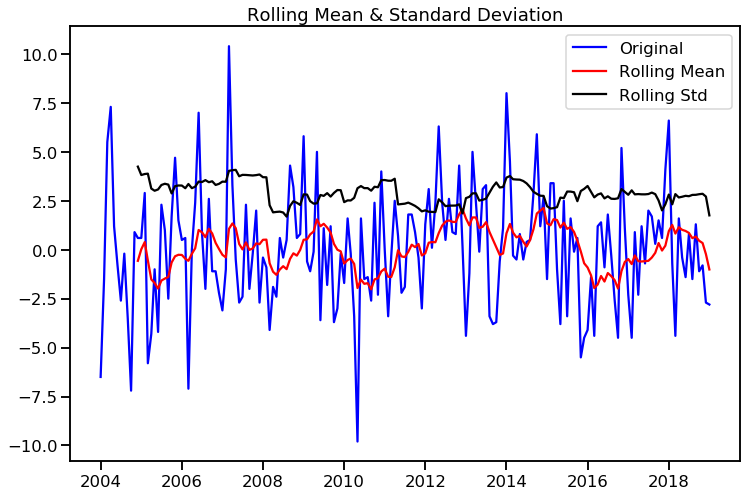

Results of Dickey-Fuller Test:
Test Statistic                  -4.149893
p-value                          0.000800
#Lags Used                      14.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


In [116]:
test_stationarity(CA_t_12['2004':])

From at least 2004 and onwards we appear to have a stationary time series with a seasonal difference. However, this does not appear to be the cast for the series from 2008 onwards:

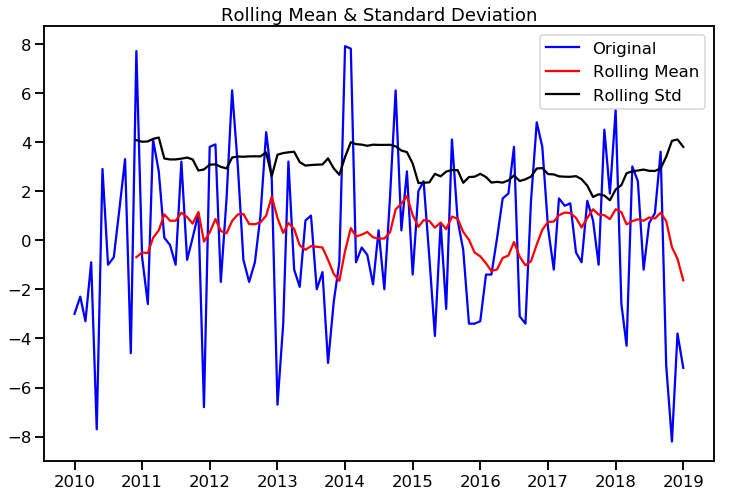

Results of Dickey-Fuller Test:
Test Statistic                 -3.086238
p-value                         0.027589
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [168]:
test_stationarity(all_dfs_diff_12['tavg']['AZ']['2010':])

We'll now turn to testing the stationarity of the time series for all of our states, since in the end we will want to apply our SARIMA model to all of our individual time series in order to make predictions.

In [118]:
def calc_d_fuller(df_dict, metric, start_year, lags=None):
    """
    Runs a Dickey-Fuller test for all state time series within a given dataframe.
    Returns a DataFrame with the Results of the Dickey-Fuller test for each state time 
    series. 
    """
    df = df_dict[metric][start_year:]
    if lags:
        df = 
    
    test_stats, p_vals, n_lags = {}, {}, {}
    
    for state in df_dict[metric].columns:
        results = adfuller(df_dict[metric][state][start_year:], autolag='AIC')
        test_stats[state] = results[0]
        p_vals[state] = results[1]
        n_lags[state] = results[2]
        
    results_df = pd.DataFrame([test_stats, p_vals, n_lags],
                              index=['test_stat', 'p_value', 'n_lags'])
    
    return results_df.T
        

In [169]:
all_dfs_diff_12 = {metric: differencer(all_dfs[metric])[0] for metric in metrics}
all_metric_dfuller = {metric: calc_d_fuller(all_dfs_diff_12, metric, '2010') for metric in metrics}

In [170]:
dfuller_results = {metric: np.sum(all_metric_dfuller[metric]['p_value'] >= 0.05) for metric in metrics}
dfuller_results

{'tavg': 8,
 'tmax': 7,
 'tmin': 11,
 'pcp': 3,
 'cdd': 3,
 'hdd': 8,
 'pdsi': 34,
 'phdi': 42,
 'pmdi': 39}

In [171]:
all_metric_dfuller['tavg'][all_metric_dfuller['tavg']['p_value'] >= 0.05]

,test_stat,p_value,n_lags
AL,-2.589239,0.095242,12.0
CA,-2.430956,0.133189,13.0
GA,-2.792720,0.059321,13.0
MT,-2.275730,0.179915,13.0
NM,-2.859711,0.050238,13.0
NV,-2.771384,0.062479,12.0
OK,-2.534756,0.107245,11.0
SC,-2.750712,0.065666,13.0


With differences of 12 months, most of the temperature time series end up being stationary. As a rule of thumb, the total order of differencing for a SARIMA model shouldn't be greater than 2. And since we're already doing seasonal differencing for all of the time series, we'll only be using models with at most 1 order of monthly differencing. By restricting d to 0 or 1, we've greatly restricted the total number of possible models that a time series can have. This makes the problem of finding time series models for all of the states with an auto-SARIMA approach much more tractable. We will now try to implement such a method with an initial restriction that both the MA and AR terms, as well as the SAR and SMA terms, cannot be greater than 1. After evaluating the performance of these models, we will then perform another grid search with 2nd order parameters and do another performance test. We'll do an 80/20 train/test split to test for model accuracy. This gives us 86 months of training and 22 months of validation if we start at 2010-01-01 and end at 2019-01-01.

### Implementing Auto-ARIMA
For now we'll just try to get working models for the temperature data. The results from the model selection will be stored in a dataframe indexed by state and temperature metric, with columns for the order, seasonal order, AIC, BIC, and MSE. We'll also want to return a dictiomary of dataframes which contains our predictions for the test sets of each metric and state so that we can prepare visuals.

In [ ]:
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

def all_temp_auto_arima(df_dict):
    """
    Performs auto_arima on each of the temperature timeseries dataframes in the dataframe dictionary.
    Returns a dictionary of dataframes with forecasts for the test sets, as well as a dataframe containing
    the order, seasonal order, AIC, BIC, and MSE for the models that are chosen for each metric and state.
    """
    

In [255]:
import itertools

def auto_arima(ts, max_order):
    p = d = q = range(0, max_order + 1)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(ts,
                      order=comb,
                      seasonal_order=combs,
                      trend='t',
                      enforce_stationarity=False,
                      enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {} : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
                
    ans = pd.DataFrame(ans)
    ans.columns = ['order', 'seasonal_order', 'AIC']
    return ans

In [749]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams



def sarimax_one_step(ts, order, s_order, ylabel, title,
                     start_year='2012-01-01', end_year='2018-01-01'):
    """
    Fits a sarima model for the given order and performs one-step ahead
    forecasting for validation.
    """
    
    model = SARIMAX(ts, order=order, 
                    seasonal_order=s_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    start=start_year,
                    trend='t',
                    end=end_year)
    
    results = model.fit()
    pred = results.get_prediction(start=end_year, dynamic=False)
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 14,5
    
    ax = ts['1990':].plot(label='Actual Data')
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9)
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)    
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.legend()
    
def sarimax_dynamic(ts, order, s_order, ylabel, title, start_year='2010-01-01',
                    end_year='2018-01-01'):
    """
    Fits a sarima model for the given order and performs one-step ahead
    forecasting for validation.
    """
    
    model = SARIMAX(ts[start_year:], order=order, 
                    seasonal_order=s_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    trend='ct')
    
    results = model.fit()
    pred_dynamic = results.get_prediction(start=start_year, 
                                          end='2024-01-01',
                                          dynamic=end_year,
                                          full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    
    rcParams['figure.figsize'] = 14,5
    
    ax = ts['1990':].plot(label='Actual Data')
    pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)
    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1],
                    color='g', alpha=.5, label='Confidence Interval')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title)

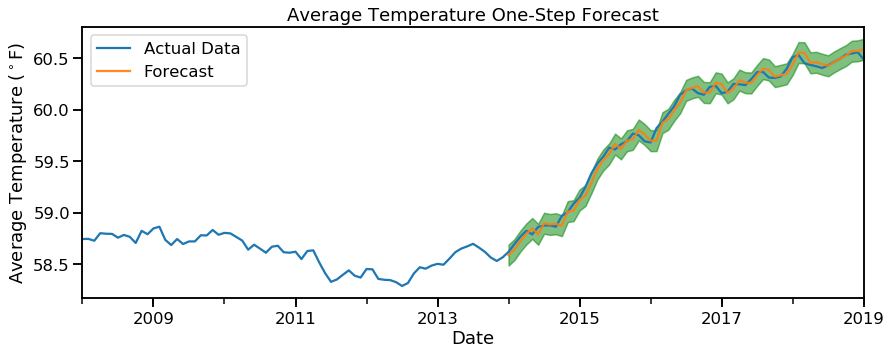

In [707]:
sarimax_one_step(roll_mean_CA_avg_t['2008':], order=(1,0,2), s_order=(0,0,0,12),
                title='Average Temperature One-Step Forecast', ylabel='Average Temperature ($^\circ$F)',
                end_year='2014-01-01')

In [759]:
sarimax_dynamic(roll_mean_CA_avg_t, order=(1,0,1), s_order=(1,1,2,12),
                title='Average Temperature Dynamic Forecast', ylabel='Average Temperature ($^\circ$F)',
                start_year='2015-01-01', end_year='2017-01-01')
plt.xlim('2012','2024')
plt.legend(loc=2)
plt.savefig('visuals/temp_forecast.png')

ValueError: maxlag should be < nobs

In [760]:
sarimax_dynamic(roll_mean_CA_cdd['2012-01-01':], order=(1,0,1), s_order=(1,1,2,12),
                title='CDD Dynamic Forecast', ylabel='CDD ($^\circ$F)',
                start_year='2016-01-01', end_year='2018-01-01')
plt.xlim('2012','2024')
plt.legend(loc=2)
plt.savefig('visuals/cdd_forecast.png')

ValueError: maxlag should be < nobs

In [753]:
sarimax_dynamic(roll_mean_CA_pcp['2012-01-01':], order=(1,0,1), s_order=(1,1,2,12),
                title='Precipitation Dynamic Forecast', ylabel='Precipitation (Inches)',
                start_year='2017-01-01', end_year='2019-01-01')
plt.xlim('2012','2024')
plt.savefig('visuals/pcp_forecast.png')

ValueError: maxlag should be < nobs

Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=-56.687, BIC=-53.520, Fit time=0.033 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=-63.053, BIC=-56.719, Fit time=0.251 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=-58.680, BIC=-57.097, Fit time=0.025 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=-64.433, BIC=-59.683, Fit time=0.050 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=-72.045, BIC=-65.711, Fit time=0.066 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=-70.648, BIC=-62.730, Fit

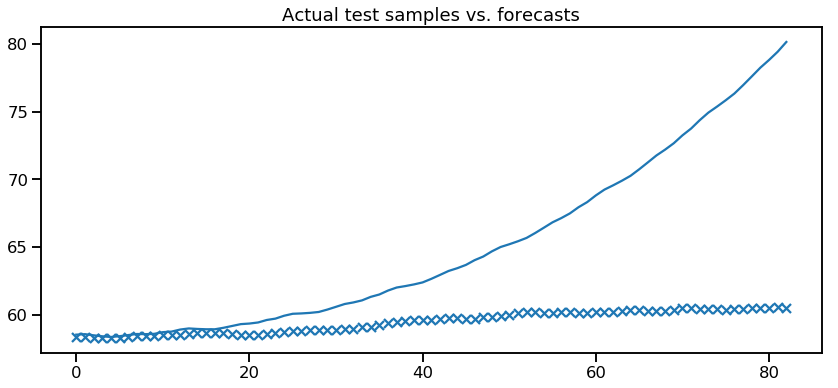

In [456]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# #############################################################################
# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(roll_mean_CA_avg_t['2008':], train_size=50)

# Fit a simple auto_arima model
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      max_p=3, max_q=3, D=1,
                      test='adf',
                      seasonal=True, m=12, 
                      stepwise=True)

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [280]:
len(CA_avg_t['2000':])*0.75

171.75